In [1]:
%conda info


     active environment : dl38
    active env location : /opt/conda/envs/dl38
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.10.1
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __linux=4.4.0=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : https://repo.anaconda.com/pkgs/main
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.c

# EDA

## Overview

### 개요

"한국에서 가장 오래된 나무는 무엇일까?" 이런 궁금한 질문이 있을 때 검색엔진에 가서 물어보신 적이 있을텐데요, 요즘엔 특히나 놀랍도록 정확한 답변을 주기도 합니다. 어떻게 가능한 걸까요?

질의 응답(Question Answering)은 다양한 종류의 질문에 대해 대답하는 인공지능을 만드는 연구 분야입니다. 그 중에서도 Open-Domain Question Answering 은 주어지는 지문이 따로 존재하지 않고 사전에 구축되어있는 knowledge resource 에서 질문에 대답할 수 있는 문서를 찾는 과정이 추가가 되어야하기에 더 어려운 문제입니다.

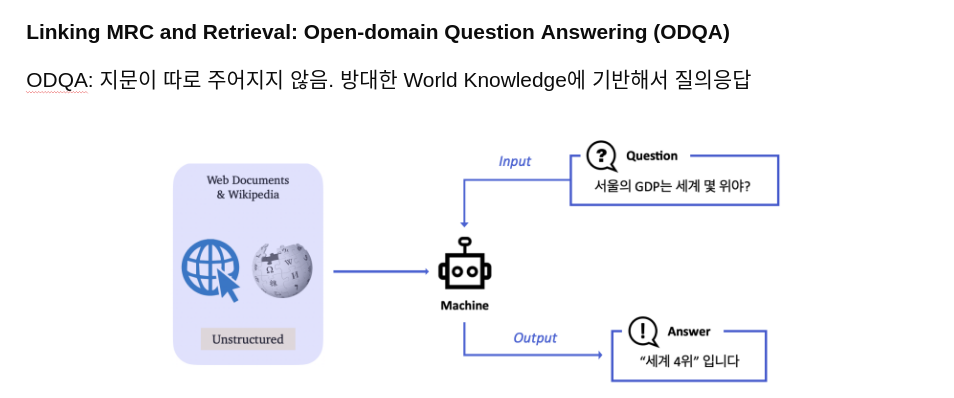

본 대회에서 우리가 만들 모델은 두 stage로 구성되어 있습니다. 첫 번째 단계는 질문에 관련된 문서를 찾아주는 "retriever"단계이고요, 다음으로는 관련된 문서를 읽고 간결한 답변을 내보내 주는 "reader" 단계입니다. 이 두 단계를 각각 만든 뒤 둘을 이으면, 어려운 질문을 던져도 척척 답변을 해주는 질의응답 시스템을 여러분 손으로 직접 만들게 됩니다. 더 정확한 답변을 내주는 모델을 만드는 팀이 우승을 하게 됩니다.

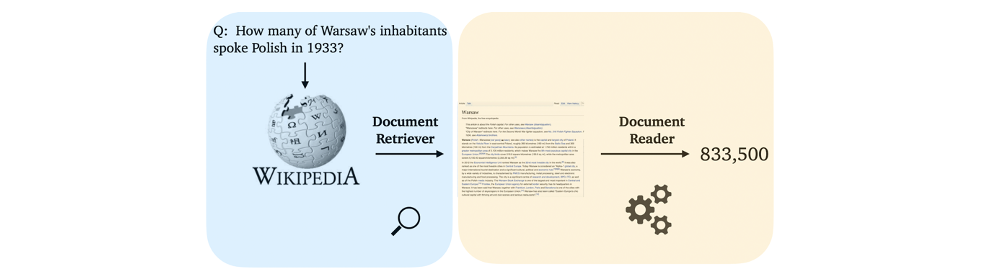

### evaluation metics

평가방법은 두가지입니다.

1. Exact Match (EM): 
    - 모델의 예측과, 실제 답이 정확하게 일치할 때만 점수가 주어집니다. 즉 각 질문마다 0점 아니면 1점입니다. 다만 띄어쓰기나 "."과 같은 문자가 포함돼 있다고 오답으로 처리되면 억울하겠죠? 이런 것은 지우고 일치하는지 확인합니다. 또한 답이 하나가 아닐 수 있는데, 이런 경우는 하나라도 일치하면 정답으로 간주합니다.
    - 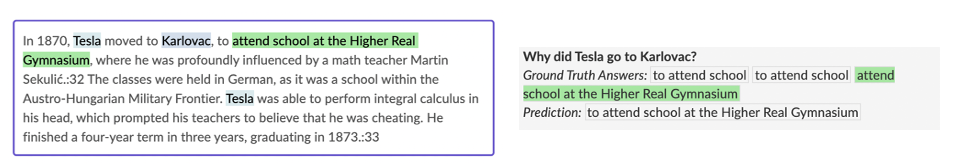
2. F1 Score: 
    - EM과 다르게 부분 점수를 제공합니다. 예를 들어, 정답은 "Barack Obama"지만 예측이 "Obama"일 때, EM의 경우 0점을 받겠지만 F1 Score는 겹치는 단어도 있는 것을 고려해 부분 점수를 줍니다.
    - 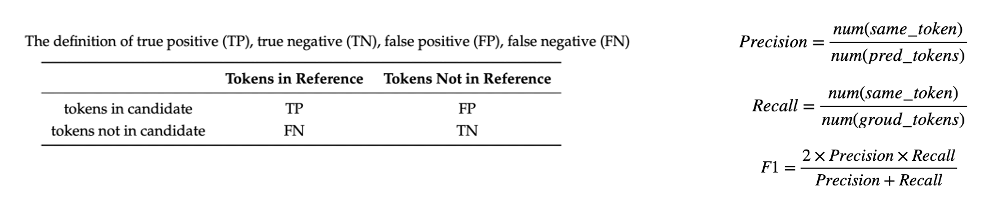

EM 기준으로 랭킹을 산정하고, F1은 참고용으로만 활용합니다.

## Import libraries

In [2]:
import os, sys
from pathlib import Path
from glob import glob

In [3]:
BASE_PATH = Path('.').resolve().parent
BASE_PATH

PosixPath('/opt/ml/jaepil')

In [4]:
sys.path.append(BASE_PATH.as_posix())

In [5]:
sys.path

['/opt/ml/jaepil/code',
 '/opt/conda/envs/dl38/lib/python38.zip',
 '/opt/conda/envs/dl38/lib/python3.8',
 '/opt/conda/envs/dl38/lib/python3.8/lib-dynload',
 '',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages/datasets-1.2.1-py3.8.egg',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages/IPython/extensions',
 '/opt/ml/.ipython',
 '/opt/ml/jaepil']

In [6]:
import numpy as np
import pandas as pd

In [7]:
import pyarrow as pa

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# matplotlib 한국어 폰트
font_path = './fonts/NanumBarunGothic.ttf'
font = mpl.font_manager.FontProperties(fname=font_path, size=9)

plt.rc('font', family='NanumBarunGothic')

In [10]:
import json
import pickle

In [11]:
from tqdm import tqdm
# from tqdm.notebook import tqdm
from time import time

In [12]:
import re

In [13]:
import torch

torch.cuda.is_available()

True

In [14]:
import datasets 

In [15]:
## custom libraries: requires konlpy, mecab

import trainer_qa
import utils_qa

## Load data

In [16]:
data_path = BASE_PATH / "input" / "data" / "data"
data_path

PosixPath('/opt/ml/jaepil/input/data/data')

In [17]:
train_path = data_path / "train_dataset"

train_data_path = train_path / "train"
val_data_path = train_path / "validation"

In [18]:
test_path = data_path / "test_dataset"

test_data_path = test_path / "validation"

In [19]:
with open(data_path / "wikipedia_documents.json", "r", encoding='utf-8') as j:
    wiki_docs_json = json.load(j)

In [20]:
wiki_docs_df = pd.DataFrame(wiki_docs_json.values())
wiki_docs_df.drop_duplicates(inplace=True)
wiki_docs_df

text corpus_source   url  \
0      이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...         위키피디아  TODO   
1      이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...         위키피디아  TODO   
2      현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...         위키피디아  TODO   
3      아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...         위키피디아  TODO   
4      저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...         위키피디아  TODO   
...                                                  ...           ...   ...   
60608  오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...         위키피디아  None   
60609  1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...         위키피디아  None   
60610  박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...         위키피디아  None   
60611  단결권 및 단체교섭권 협약(Right to Organise and Collectiv...         위키피디아  None   
60612  이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...         위키피디아  None   

      domain            title author  html  document_id  
0       None            나라 목록   None  None            0  
1       None            나라 목록   None  None            1  
2       None              백남준   None  None            2  
3       None          아오조라 문고   None  None            3  
4       None          아오조라 문고   None  None            4  
...      ...              ...    ...   ...          ...  
60608   None  오키나와 현립 박물관·미술관   None  None        60608  
60609   None  오키나와 현립 박물관·미술관   None  None        60609  
60610   None  오키나와 현립 박물관·미술관   None  None        60610  
60611   None   단결권 및 단체교섭권 협약   None  None        60611  
60612   None   단결권 및 단체교섭권 협약   None  None        60612  

[60613 rows x 8 columns]

In [21]:
train_dataset = datasets.load_from_disk(train_data_path)
train_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})

In [22]:
train_df = pd.DataFrame(train_dataset)
train_df.head()

title                                            context  \
0    미국 상원  미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...   
1   인사조직관리  '근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...   
2      강희제  강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...   
3   금동삼존불감  불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...   
4  계사명 사리구  동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...   

                                  question            id  \
0         대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?  mrc-1-000067   
1                   현대적 인사조직관리의 시발점이 된 책은?  mrc-0-004397   
2           강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?  mrc-1-000362   
3  11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?  mrc-0-001510   
4               명문이 적힌 유물을 구성하는 그릇의 총 개수는?  mrc-0-000823   

                                         answers  document_id  \
0        {'answer_start': [235], 'text': ['하원']}        18293   
1  {'answer_start': [212], 'text': ['《경영의 실제》']}        51638   
2        {'answer_start': [510], 'text': ['백성']}         5028   
3        {'answer_start': [625], 'text': ['중국']}        34146   
4         {'answer_start': [30], 'text': ['4개']}        47334   

   __index_level_0__  
0                 42  
1               2873  
2                230  
3                992  
4                548

In [23]:
val_dataset = datasets.load_from_disk(val_data_path)
val_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})

In [24]:
val_df = pd.DataFrame(val_dataset)
val_df.head()

title                                            context  \
0    전효숙  순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...   
1  스토우빌선  요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...   
2     촐라  촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...   
3  백조 기사  프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...   
4  탈관료제화  탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...   

                               question            id  \
0        처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?  mrc-0-003264   
1  스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?  mrc-0-004762   
2       촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?  mrc-1-001810   
3              로타이르가 백조를 구하기 위해 사용한 것은?  mrc-1-000219   
4    의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?  mrc-1-000285   

                                       answers  document_id  __index_level_0__  
0    {'answer_start': [284], 'text': ['한보철강']}         9027               2146  
1   {'answer_start': [146], 'text': ['1871년']}        51765               3106  
2     {'answer_start': [517], 'text': ['나뭇잎']}        15694               1180  
3    {'answer_start': [1109], 'text': ['금대야']}        59536                141  
4  {'answer_start': [386], 'text': ['수평적 관계']}        32991                184

In [25]:
test_dataset = datasets.load_from_disk(test_data_path)
test_dataset

Dataset({
    features: ['id', 'question'],
    num_rows: 600
})

In [26]:
test_df = pd.DataFrame(test_dataset)
test_df.head()

question            id
0                    유령'은 어느 행성에서 지구로 왔는가?  mrc-1-000653
1          용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?  mrc-1-001113
2  돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?  mrc-0-002191
3     마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?  mrc-0-003951
4               디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?  mrc-1-001272

## Data stats

### `answers`의 특성은 어떻게 되는가? 

In [27]:
train_answers_df = pd.DataFrame(list(train_df.answers))
train_answers_df

answer_start          text
0           [235]          [하원]
1           [212]    [《경영의 실제》]
2           [510]          [백성]
3           [625]          [중국]
4            [30]          [4개]
...           ...           ...
3947        [317]       [지질 구조]
3948        [616]         [뉴저지]
3949        [255]      [칼 에케르트]
3950        [476]      [슬라브 신화]
3951        [189]  [크리스토포 알하우스]

[3952 rows x 2 columns]

In [28]:
val_answers_df = pd.DataFrame(list(val_df.answers))
val_answers_df

answer_start             text
0          [284]           [한보철강]
1          [146]          [1871년]
2          [517]            [나뭇잎]
3         [1109]            [금대야]
4          [386]         [수평적 관계]
..           ...              ...
235       [1084]           [제 양왕]
236        [343]  ['일곱 개의 신전 광장']
237        [247]         [미나미 지로]
238        [563]       [200,000명]
239        [811]           [공산주의]

[240 rows x 2 columns]

`answer_start` list에 2개 이상의 원소가 들어있거나 원소가 없는 경우도 존재하는가? 

In [29]:
[l for l in train_answers_df.answer_start if len(l) != 1] # 없다. answer_start는 항상 길이가 1이다. 

[]

`text`는 space 기준으로 나눴을 때 최대 몇 n그램을 가지는가? 

각 `text`에 들어있는 space의 갯수를 `Counter`로 확인해보자. 

In [30]:
from collections import Counter

In [31]:
text_temp = [Counter(t[0]) for t in train_answers_df.text]
text_temp = [c[' '] for c in text_temp]
Counter(text_temp)

Counter({0: 2288,
         1: 1065,
         2: 349,
         4: 52,
         7: 7,
         5: 39,
         3: 120,
         6: 18,
         14: 1,
         8: 4,
         12: 1,
         19: 1,
         9: 3,
         13: 2,
         17: 1,
         15: 1})

<AxesSubplot:ylabel='count'>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


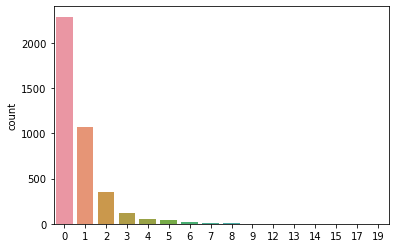

In [32]:
sns.countplot(x=text_temp)

In [33]:
text_temp.index(19)

996

In [34]:
train_answers_df.text[996]

['“나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”']

In [35]:
train_df.iloc[996]

title                                                              윤치호
context              3·1 운동\n1919년 3월 3·1 운동 당시, 독립운동가들로부터 국민대표로 서명...
question                          윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?
id                                                        mrc-0-002792
answers              {'answer_start': [1122], 'text': ['“나는 국경일에 일장...
document_id                                                       5307
__index_level_0__                                                 1833
Name: 996, dtype: object

`id`의 중간 숫자는 어떤 의미가 있는가?

특별히 의미는 없는 것 같다. 뭔가 있다해도 이걸 쓰는건 cheating인듯..  

In [36]:
ids_l = list(train_df.id)

ids_0_l = [x for x in ids_l if x.split('-')[1] == '0']
ids_1_l = [x for x in ids_l if x.split('-')[1] == '1']

ids_etc_l = [x for x in ids_l if x.split('-')[1] != '1' and x.split('-')[1] != '0'] # [] 

In [37]:
id_0_df = train_df[train_df.id.isin(ids_0_l)]
id_0_df

title                                            context  \
1                인사조직관리  '근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...   
3                금동삼존불감  불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...   
4               계사명 사리구  동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...   
5                   용아병  델포이의 신탁에 따라 암소를 따라간 카드모스는 테베 땅에 이르렀다. 카드모스는 암소...   
6                    호반  제27회와 제73회에 출현한다. 관우는 자신을 저지하는 공수, 맹탄, 한복, 변희를...   
...                 ...                                                ...   
3946             막리지의 난  628년에 당이 마지막 남은 군벌 세력과 서돌궐을 제거하고 통일하였듯, 당의 성장을...   
3947            이오 (위성)  이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...   
3949        빈 필하모니 관현악단  1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...   
3950                드래곤  원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...   
3951  2011년 함부르크 주의회 선거  2008년 2월 28일 실시된 2008년 함부르크 주의회 선거에서 기민련은 과반수 ...   

                                     question            id  \
1                      현대적 인사조직관리의 시발점이 된 책은?  mrc-0-004397   
3     11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?  mrc-0-001510   
4                  명문이 적힌 유물을 구성하는 그릇의 총 개수는?  mrc-0-000823   
5                  카드모스의 부하들이 간 곳에는 무엇이 있었는가?  mrc-0-005265   
6                       관우를 불태워 죽이려한 사람 누구인가?  mrc-0-000532   
...                                       ...           ...   
3946       영류왕이 천리장성의 건축 총괄 책임을 맡겼던 인물은 누구인가?  mrc-0-004590   
3947             대부분의 이오의 산이 형성되는데 영향을 끼친 것은?  mrc-0-005285   
3949     1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?  mrc-0-003429   
3950                      드래곤의 암수 구분이 있는 신화는?  mrc-0-003956   
3951         올레 폰 보이스트 이후에 시장으로 임명된 사람은 누구인가?  mrc-0-003589   

                                              answers  document_id  \
1       {'answer_start': [212], 'text': ['《경영의 실제》']}        51638   
3             {'answer_start': [625], 'text': ['중국']}        34146   
4              {'answer_start': [30], 'text': ['4개']}        47334   
5             {'answer_start': [91], 'text': ['드래곤']}        37482   
6         {'answer_start': [68], 'text': ['형양태수 왕식']}        24395   
...                                               ...          ...   
3946    {'answer_start': [474], 'text': ['연태조(淵太祚)']}        59702   
3947       {'answer_start': [317], 'text': ['지질 구조']}         8275   
3949      {'answer_start': [255], 'text': ['칼 에케르트']}        12730   
3950      {'answer_start': [476], 'text': ['슬라브 신화']}        10924   
3951  {'answer_start': [189], 'text': ['크리스토포 알하우스']}        27803   

      __index_level_0__  
1                  2873  
3                   992  
4                   548  
5                  3429  
6                   360  
...                 ...  
3946               2996  
3947               3445  
3949               2252  
3950               2595  
3951               2354  

[2957 rows x 7 columns]

In [38]:
id_1_df = train_df[train_df.id.isin(ids_1_l)]
id_1_df

title                                            context  \
0             미국 상원  미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...   
2               강희제  강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...   
10    황해 해전 (1894년)  이후, 여순항에 피항한 북양함대는 일본 육군에 의해 육지로부터 포위될 뻔 했다. 북...   
14              레위기  너는 이스라엘 백성 온 회중에게 이렇게 일러주어라. '나 야훼 너희 하느님이 거룩하...   
15               권번  권번은 주식회사 제도로 운영되었으며 일제가 그 관리를 주도하였다. 일제가 권번을 관...   
...             ...                                                ...   
3926     교황 니콜라오 2세  니콜라오 2세는 자신의 지위를 확고히 하기 위해 즉시 노르만족과 우호적인 관계를 맺...   
3931          포베글리아  포베글리1년 파두아(*북부 이탈리아 도시)로부터 전염병을 피해 이주한 곳으로 처음 ...   
3935          델라웨어주  델라웨어 주는 노예제 찬성 주였으며, 합중국의 초기 13개의 주들 중 하나이기도 하...   
3945     미국 알래스카 육군  1940년, 제2차 세계 대전에 대비하기 위해 알래스카 방위군이 창설되었다. 랜드리...   
3948        내니 다이어리  애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...   

                                    question            id  \
0           대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?  mrc-1-000067   
2             강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?  mrc-1-000362   
10                             정여창은 어떻게 죽었나?  mrc-1-000128   
14                   유대교의 지나친 차별을 타파하려한 사람은?  mrc-1-001008   
15                 권번에서 요릿집에 제공한 기생 명부의 이름은?  mrc-1-000732   
...                                      ...           ...   
3926  니콜라오 2세가 장엄한 예식을 주재함으로써 우호관계를 형성한 세력은?  mrc-1-000678   
3931         1379년에 이탈리아의 주요 거점지로 인정받았던 장소는?  mrc-1-001779   
3935                   링컨이 노예 해방 선언을 공표한 해는?  mrc-1-000169   
3945             알래스카 고속도로가 미국 본토에 수행하는 역할은?  mrc-1-000818   
3948                          애니는 어디서 태어났는가?  mrc-1-000699   

                                                answers  document_id  \
0               {'answer_start': [235], 'text': ['하원']}        18293   
2               {'answer_start': [510], 'text': ['백성']}         5028   
10            {'answer_start': [817], 'text': ['음독자살']}        26376   
14              {'answer_start': [497], 'text': ['예수']}         5251   
15           {'answer_start': [524], 'text': [''초일기'']}        47810   
...                                                 ...          ...   
3926          {'answer_start': [355], 'text': ['노르만족']}         6743   
3931            {'answer_start': [93], 'text': ['베니스']}        25523   
3935         {'answer_start': [215], 'text': ['1863년']}         5973   
3945  {'answer_start': [295], 'text': ['병력과 물류를 보급할 ...        35815   
3948           {'answer_start': [616], 'text': ['뉴저지']}        37764   

      __index_level_0__  
0                    42  
2                   230  
10                   80  
14                  652  
15                  471  
...                 ...  
3926                436  
3931               1163  
3935                109  
3945                529  
3948                450  

[995 rows x 7 columns]

## Export df pkl files 

In [39]:
export_path = BASE_PATH / "input" / "processed_data"
export_path

PosixPath('/opt/ml/jaepil/input/processed_data')

In [40]:
wiki_docs_df.to_pickle(export_path / 'wiki_docs_df.pkl')
train_df.to_pickle(export_path / 'train_df.pkl')
val_df.to_pickle(export_path / 'val_df.pkl')

## Explore stats

### simple length

In [51]:
train_context_length = train_df.context.apply(len)
train_question_length = train_df.question.apply(len)
wiki_text_length = wiki_docs_df.text.apply(len)

<AxesSubplot:>

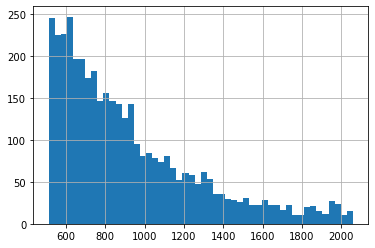

In [49]:
train_context_length.hist(bins=50)

<AxesSubplot:>

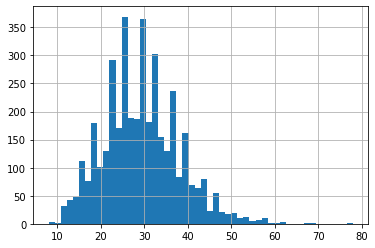

In [50]:
train_question_length.hist(bins=50)

<AxesSubplot:>

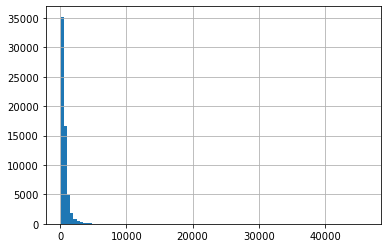

In [55]:
wiki_text_length.hist(bins=100)

### tokenized length

In [39]:
from pororo import Pororo

In [41]:
np.random.seed(123)
random_idx = np.random.choice(100, 20)
random_idx

array([66, 92, 98, 17, 83, 57, 86, 97, 96, 47, 73, 32, 46, 96, 25, 83, 78,
       36, 96, 80])

In [56]:
example_df = train_df.iloc[random_idx]
example_df.head()

title                                            context  \
66   기세이 본선  나고야 방면으로 직결 운행하는 열차로는 쾌속 《미에》 호가 쓰 역과 다키 역 사이를...   
92   덴노즈아이루  덴노즈아이루(天王洲アイル)는 일본 도쿄도 시나가와구 히가시시나가와 임해부에 있는 재...   
98      텀블벅  텀블벅(tumblbug)의 특징은 역시 다양한 분야에 다양한 시도들을 적극 권장하며...   
17  팀 웨이크필드  2009년 웨이크필드는 레드삭스와 함께 자신의 15번째 시즌에 들어갔다. 4월 15...   
83   오토망게어족  오토망게어족(Oto-Manguean languages)은 여러 아메리카 원주민 언어...   

                                     question            id  \
66          쾌속 《미에》 호는 어느 방향으로 직결 운행하는 열차인가요?  mrc-0-001337   
92          도카이도 신칸센이 지나가며 시나가와 역까지 가는 교통수단은?  mrc-0-003354   
98  정해진 기간동안 목표 금액에 도달하지 못할 경우 돈을 받지 못하는 사람은?  mrc-0-003303   
17                웨이크필드가 15번째 시즌에 활약한 팀의 이름은?  mrc-0-000424   
83                오토망게어족을 가장 많이 사용하는 곳은 어디인가?  mrc-1-001688   

                                        answers  document_id  \
66       {'answer_start': [0], 'text': ['나고야']}        30248   
92  {'answer_start': [230], 'text': ['도에이 버스']}        44283   
98     {'answer_start': [380], 'text': ['창작자']}        33445   
17     {'answer_start': [13], 'text': ['레드삭스']}        52733   
83   {'answer_start': [214], 'text': ['오아하카주']}        55072   

    __index_level_0__  
66                878  
92               2205  
98               2172  
17                285  
83               1109

In [56]:
Pororo.available_models('tokenize')

'Available models for tokenize are ([lang]: en, [model]: moses, bpe32k.en, roberta, sent_en), ([lang]: ko, [model]: bpe4k.ko, bpe8k.ko, bpe16k.ko, bpe32k.ko, bpe64k.ko, unigram4k.ko, unigram8k.ko, unigram16k.ko, unigram32k.ko, unigram64k.ko, jpe4k.ko, jpe8k.ko, jpe16k.ko, jpe32k.ko, jpe64k.ko, mecab.bpe4k.ko, mecab.bpe8k.ko, mecab.bpe16k.ko, mecab.bpe32k.ko, mecab.bpe64k.ko, char, jamo, word, mecab_ko, sent_ko), ([lang]: ja, [model]: mecab, bpe8k.ja, sent_ja), ([lang]: zh, [model]: jieba, sent_zh)'

안됨:
- `jpe32k.ko`: `<unk>` 가 없다 함. 
- `mecab_ko`: 따로 설치해야 하는듯 


#### `model='bpe32k.ko'`

In [57]:
tk = Pororo(task='tokenization', lang='ko', model='bpe32k.ko')
tk

[TASK]: TOKENIZATION
[LANG]: KO
[MODEL]: bpe32k.ko

In [59]:
%%time

example_tk_question = train_df.question.apply(tk)
example_tk_question

CPU times: user 384 ms, sys: 0 ns, total: 384 ms
Wall time: 386 ms


0       [▁대통령을, ▁포함한, ▁미국의, ▁행정부, ▁견제, 권을, ▁갖는, ▁국가, ▁...
1         [▁현대, 적, ▁인사, 조직, 관, 리의, ▁시, 발, 점이, ▁된, ▁책은, ?]
2       [▁강희, 제가, ▁17, 17, 년에, ▁쓴, ▁글은, ▁누구를, ▁위해, ▁쓰여...
3       [▁11, ~12, 세기에, ▁제작된, ▁본, 존, 불, 은, ▁보통, ▁어떤, ▁...
4       [▁명, 문이, ▁적힌, ▁유, 물을, ▁구성하는, ▁그릇, 의, ▁총, ▁개, 수...
                              ...                        
3947    [▁대부분의, ▁이, 오의, ▁산이, ▁형성, 되는데, ▁영향을, ▁끼친, ▁것은, ?]
3948                          [▁애니, 는, ▁어디서, ▁태어났, 는가, ?]
3949    [▁18, 54, 년에, ▁니콜라이, 의, ▁뒤를, ▁이어, ▁상임, ▁지휘, 자로...
3950               [▁드래곤, 의, ▁암, 수, ▁구분이, ▁있는, ▁신, 화는, ?]
3951    [▁올, 레, ▁폰, ▁보이, 스트, ▁이후에, ▁시장으로, ▁임명된, ▁사람은, ...
Name: question, Length: 3952, dtype: object

In [60]:
example_tk_question[0]

['▁대통령을', '▁포함한', '▁미국의', '▁행정부', '▁견제', '권을', '▁갖는', '▁국가', '▁기관은', '?']

#### `model='mecab.bpe32k.ko'`

In [71]:
tk = Pororo(task='tokenization', lang='ko', model='mecab.bpe32k.ko')
tk

[TASK]: TOKENIZATION
[LANG]: KO
[MODEL]: mecab.bpe32k.ko

In [72]:
%%time

example_tk_question = example_df.question.apply(tk)
example_tk_question

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.59 ms


66    [▁쾌속, ▁, 《, 미, 에, 》, ▁호, 는, ▁어느, ▁방향, 으로, ▁직결,...
92    [▁도카이도, ▁신칸센, 이, ▁지나가, 며, ▁시나가와, ▁역, 까, 지, ▁가,...
98    [▁정해진, ▁기간, 동안, ▁목표, ▁금액, 에, ▁도달, 하, 지, ▁못할, ▁...
17    [▁웨이크, 필드, 가, ▁15, 번, 째, ▁시즌, 에, ▁활약, 한, ▁팀, 의...
83    [▁오토, 망, 게, 어, 족, 을, ▁가장, ▁많이, ▁사용, 하, 는, ▁곳, ...
57         [▁작중, ▁샤를, ▁지, ▁브리타니아, 가, ▁비판, 한, ▁사상, 은, ?]
86                               [▁우메, 노, 의, ▁사인, 은, ?]
97    [▁김대중, 을, ▁구하, 기, ▁위해, ▁캐, 스퍼, ▁와인, 버거, ▁미, ▁국...
96     [▁소나타, 의, ▁시초, 가, ▁된, ▁연습, 곡, 을, ▁만든, ▁사람, 은, ?]
47    [▁풍수지리, 사상, 의, ▁관점, 에, 서, ▁보, 면, ▁선, 몽, 대, 는, ...
73    [▁경찰관, 이, ▁딱지, 를, ▁떼, 지, ▁않, 은, ▁것, 은, ▁무엇, 을,...
32    [▁러시아, 가, ▁IS, IL, 과, ▁타, ▁반정부, ▁단체, 와, ▁전투, 를...
46    [▁초고층, ▁주거, 에, 서, ▁차량, 과, ▁사람, 의, ▁활동, ▁범위, ▁중...
96     [▁소나타, 의, ▁시초, 가, ▁된, ▁연습, 곡, 을, ▁만든, ▁사람, 은, ?]
25    [▁툴, 민, 은, ▁, ≪, 코스, 모, 폴리스, ≫, 에, 서, ▁근대, 과학,...
83    [▁오토, 망, 게, 어, 족, 을, ▁가장, ▁많이, ▁사용, 하, 는, ▁곳, ...
78    [▁핀, ▁막, ▁쿠, 월, 이, ▁복수, 하, 고, 자, ▁하, 는, ▁아버지, ...
36    [▁차, 바, 하르, 항, 은, ▁어떤, ▁나라, ▁덕분, 에, ▁미국, 의

In [77]:
example_tk_question.iloc[0]

['▁쾌속',
 '▁',
 '《',
 '미',
 '에',
 '》',
 '▁호',
 '는',
 '▁어느',
 '▁방향',
 '으로',
 '▁직결',
 '▁운행',
 '하',
 '는',
 '▁열차',
 '인',
 '가요',
 '?']

조사 단위까지 잘 자르는 `mecab.bpe32k.`를 기준으로 eda해보겠음. 

In [79]:
%%time

train_tk_question = train_df.question.apply(tk)
train_tk_context = train_df.context.apply(tk)

CPU times: user 6.48 s, sys: 120 ms, total: 6.6 s
Wall time: 6.61 s


In [82]:
print(train_tk_context[0])

['▁미국', '▁상', '의원', '▁또는', '▁미국', '▁상원', '(', 'U', 'n', 'ited', '▁States', '▁S', 'en', 'ate', ')', '은', '▁양원제', '인', '▁미국', '▁의회', '의', '▁상원', '이', '다', '.', '\\', 'n', '\\', 'n', '미', '국', '▁부통령', '이', '▁상원', '의장', '이', '▁된다', '.', '▁각', '▁주', '당', '▁2', '명', '의', '▁상원', '의원', '이', '▁선출', '되', '어', '▁100', '명', '의', '▁상원', '의원', '으로', '▁구성', '되', '어', '▁있', '다', '.', '▁임기', '는', '▁6', '년', '이', '며', ',', '▁2', '년', '마', '다', '▁50', '개', '주', '▁중', '▁1', '/', '3', '씩', '▁상원', '의원', '을', '▁새로', '▁선출', '하여', '▁연방', '에', '▁보낸다', '.', '\\', 'n', '\\', 'n', '미', '국', '▁상원', '은', '▁미국', '▁하원', '과', '는', '▁다르', '게', '▁미국', '▁대통령', '을', '▁수반', '으로', '▁하', '는', '▁미국', '▁연방', '▁행정부', '에', '▁각종', '▁동의', '를', '▁하', '는', '▁기관', '이', '다', '.', '▁하원', '이', '▁세금', '과', '▁경제', '에', '▁대한', '▁권한', ',', '▁대통령', '을', '▁포함', '한', '▁대다수', '의', '▁공무원', '을', '▁파면', '할', '▁권한', '을', '▁갖', '고', '▁있', '는', '▁국민', '을', '▁대표', '하', '는', '▁기관', '인', '▁반면', '▁상원', '은', '▁미국', '의', '▁주', '를', '▁대표', '한다', '.', '▁즉', '

영어는 엄청 이상하게 잘렸다. 

In [83]:
train_tk_question_len = train_tk_question.apply(len)
train_tk_context_len = train_tk_context.apply(len)

<AxesSubplot:>

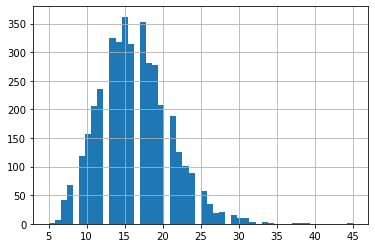

In [85]:
train_tk_question_len.hist(bins=50)

<AxesSubplot:>

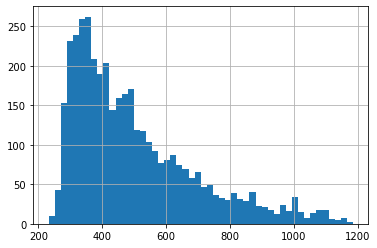

In [86]:
train_tk_context_len.hist(bins=50)